# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

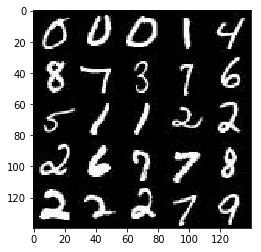

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

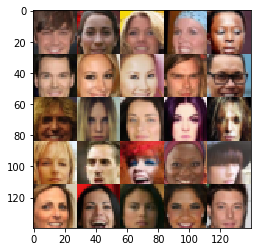

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # using conv2d on input layer, input size is 28*28*3(for celeba) or 28*28*1(for mnist)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        # no batch normalization on input layer, using leaky relu next
        relu1 = tf.maximum(alpha * x1, x1)
        
        # second conv layer, input size- 14*14*64, output size - 7*7*128
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', activation=None)
        # batch norm layer. training is set to True, as discriminator will be used only for training
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # leaky relu
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        #third conv layer, input size- 7*7*128, output size- 4*4*256
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', activation=None)
        # batch norm layer with training set to true
        bn3 = tf.layers.batch_normalization(x3, training=True)
        #leaky relu next
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # flatten the of last conv layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        # create a dense layer with one output unit
        logits = tf.layers.dense(flat, 1, activation=None)
        #sigmoid activation
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # first fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # reshape and batch norm
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        
        # fist transpose conv layer, input size- 7*7*512, output size- 14*14*256
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, 2, padding='same', activation=None)
        # batch norm followed by leaky relu
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # second transpose conv layer, output size- 28*28*128
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, 2, padding='same', activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # third transpose conv layer, using strides=1, output size - 28*28*out_channel_dim
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        # output layer with tanh activation
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # separate generator and discriminator vars
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_width, input_height, input_channel = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(input_width, input_height, input_channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, input_channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # as mentioned earlier in this notebook the pixel values in the input images are between -0.5 to 0.5
                # multiplying the values by 2 to make them fall between -1 and 1
                batch_images *= 2.0
                
                # sample random noise for z between -0.5 to 0.5 from uniform distribution
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr:learning_rate})
                
                # show losses every 100 steps
                if steps%10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, input_channel, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 5.5106
Epoch 1/2... Discriminator Loss: 2.8628... Generator Loss: 0.2715
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 5.5262
Epoch 1/2... Discriminator Loss: 1.7362... Generator Loss: 6.0917
Epoch 1/2... Discriminator Loss: 0.7962... Generator Loss: 1.7304
Epoch 1/2... Discriminator Loss: 3.1048... Generator Loss: 0.1100
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 2.7839... Generator Loss: 4.3564
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.7633


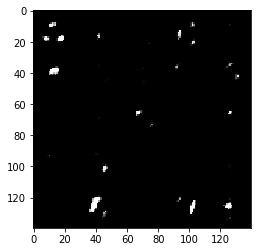

Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.7322... Generator Loss: 0.3917
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 1.7554
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 1.7884
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 2.4278
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 2.5126... Generator Loss: 4.1285
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 1.6768


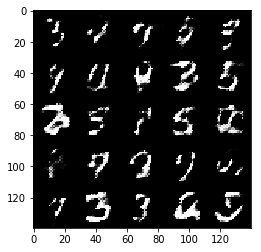

Epoch 1/2... Discriminator Loss: 3.0650... Generator Loss: 5.7282
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.7648... Generator Loss: 0.3772
Epoch 1/2... Discriminator Loss: 1.7973... Generator Loss: 0.3620
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 1.8339... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.8668
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 1.9111


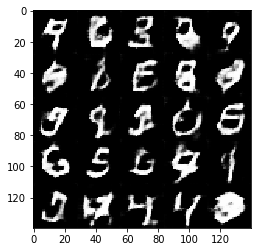

Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 1.6187
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.3606
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.6552
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 1.1635
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 1.3922


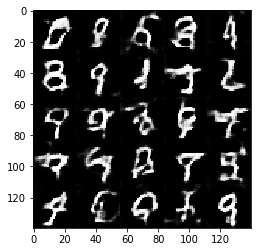

Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 1.0792
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.5624
Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 1.5676
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.7550... Generator Loss: 0.3956
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 1.8539
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.9087


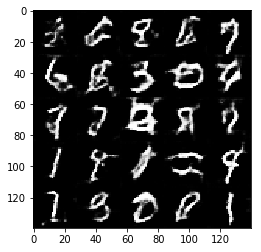

Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 1.9243
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 1.6030
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 1.0983
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 1.9262... Generator Loss: 0.3270
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 1.7295
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.7553


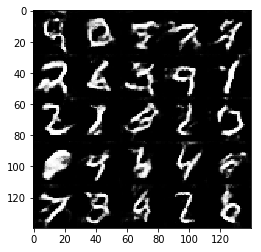

Epoch 1/2... Discriminator Loss: 1.5742... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 1.3611
Epoch 1/2... Discriminator Loss: 3.0130... Generator Loss: 3.7160
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 1.2178
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.3124


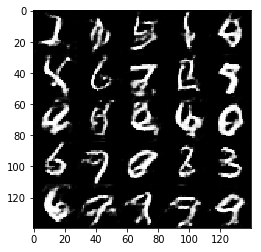

Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 1.6150
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 2.1365
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.8558
Epoch 1/2... Discriminator Loss: 1.7927... Generator Loss: 0.3453
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 1.3994


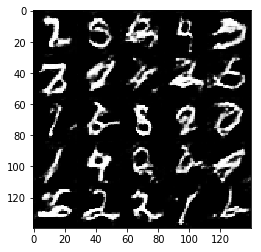

Epoch 1/2... Discriminator Loss: 1.7687... Generator Loss: 1.8048
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 1.2032
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 1.2175
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6123
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.6760


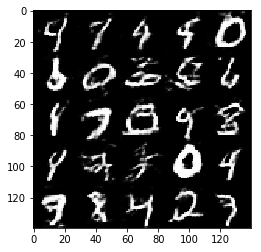

Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.2428
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 2.0749
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.6535
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.1933
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 1.4554
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.8650
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 2.5767
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.6143


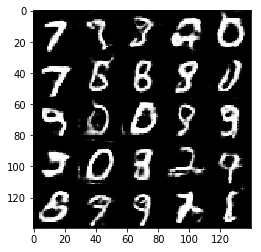

Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 1.7816
Epoch 2/2... Discriminator Loss: 1.4713... Generator Loss: 2.1531
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.8845
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 1.4855
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 1.2120
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.0028


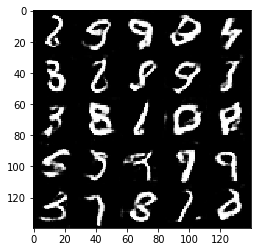

Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 1.7067
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 1.5920
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.7452
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 2.2093
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 1.7615


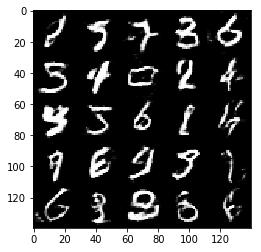

Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.4839
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.6462
Epoch 2/2... Discriminator Loss: 2.0488... Generator Loss: 0.2838
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.5896
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.6385... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.5876


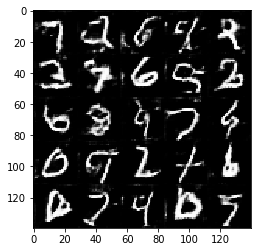

Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.5782
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 2.1227... Generator Loss: 0.2561
Epoch 2/2... Discriminator Loss: 1.1171... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.5913... Generator Loss: 0.4842
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.8235


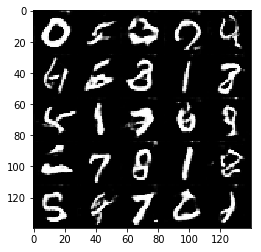

Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.7187
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 1.0146
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.9776
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 1.5128... Generator Loss: 0.5066


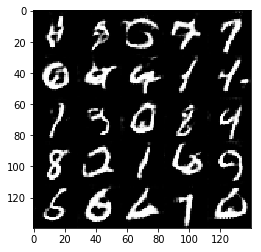

Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 1.9359
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 2.0589
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.5261
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.8105


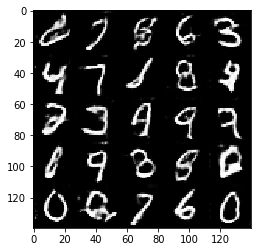

Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.5216... Generator Loss: 0.4981
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.6948
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 1.9976
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.7246


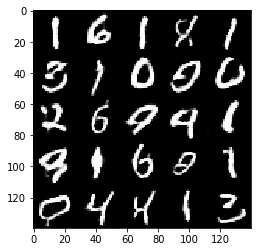

Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.5155
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.5786
Epoch 2/2... Discriminator Loss: 1.5152... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.8642


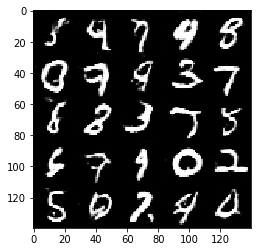

Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 2.2397
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.1155
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 1.9215
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 1.1701
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.8396


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 4.2802
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 4.5885
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 6.9198
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 6.7444
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 5.8311
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 6.5940
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 5.6337
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 5.0484
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 5.7899
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 5.3669


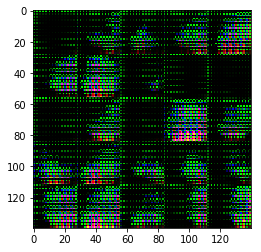

Epoch 1/1... Discriminator Loss: 1.7652... Generator Loss: 3.8667
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 2.4528
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 2.3738
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.7661
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 2.0993
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 2.1506
Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 2.5789
Epoch 1/1... Discriminator Loss: 2.0129... Generator Loss: 3.8710


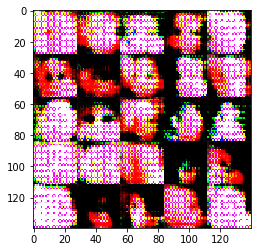

Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 2.1694... Generator Loss: 4.2481
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 2.1503
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.4633
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.6581
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 3.6856
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 4.7029
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 2.8411
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 5.4070


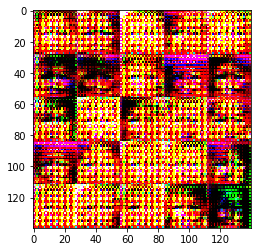

Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 3.6735
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 4.4436
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 6.7681
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 5.6211
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 2.6015
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.0536


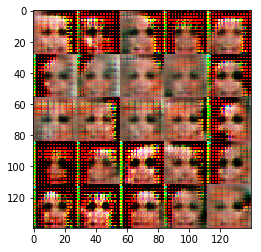

Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 7.4923
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 2.1943
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 2.5289
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.2996


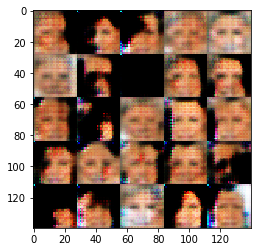

Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 1.8274... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 2.1384
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 4.3480... Generator Loss: 4.7715
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9647


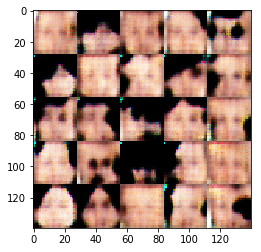

Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 1.6798... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.5178


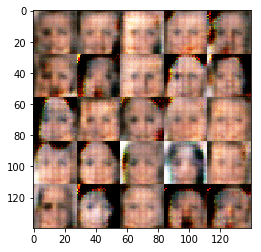

Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.6677
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 2.4590
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.3973


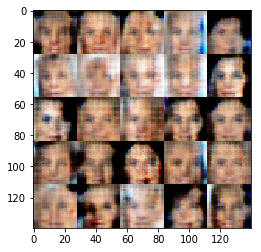

Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.6167
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 1.1005


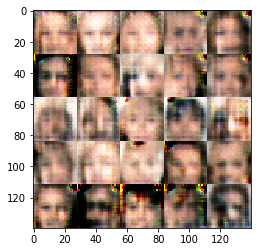

Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 2.2737... Generator Loss: 2.7678
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.3474
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6427


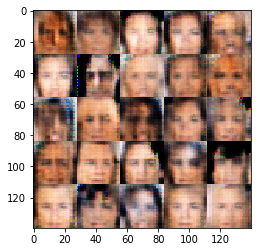

Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 1.9455... Generator Loss: 2.6566
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.0590


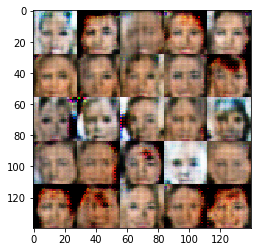

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 1.9317
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4749


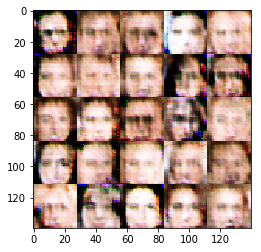

Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.9918... Generator Loss: 2.1981
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.9858


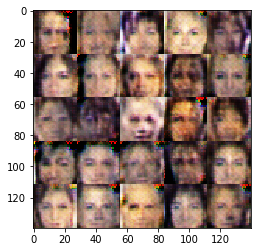

Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.8445... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 1.6949


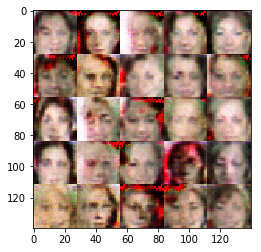

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5243


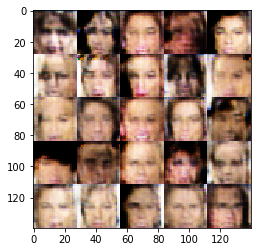

Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 1.7824
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0024


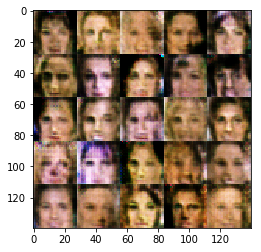

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.8262


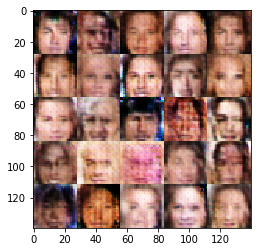

Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9051


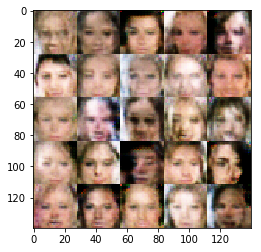

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.9015... Generator Loss: 2.1542
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 2.0972... Generator Loss: 0.2221


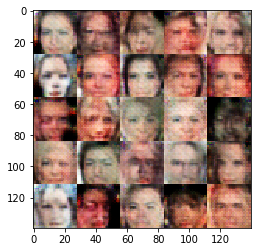

Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7765


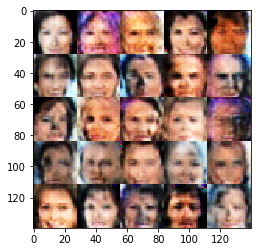

Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.0689


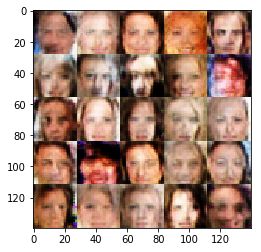

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.9086


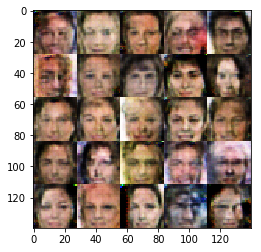

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6131


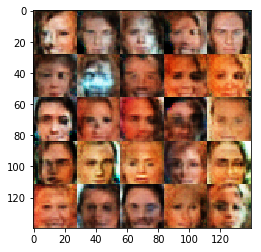

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 1.5432
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.9997


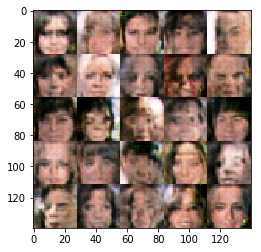

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8119


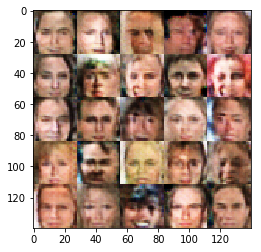

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8980


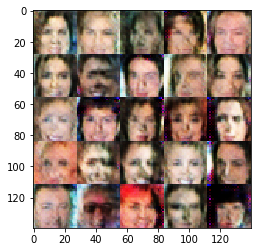

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7020


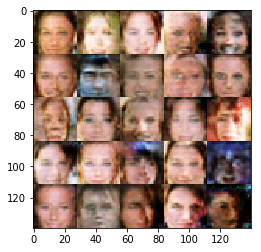

Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7147


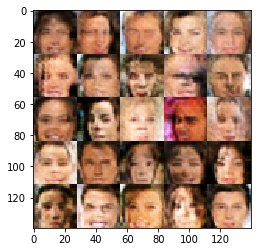

Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7986


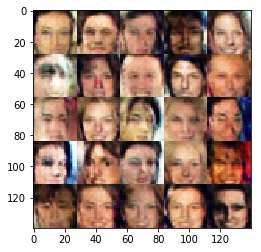

Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8105


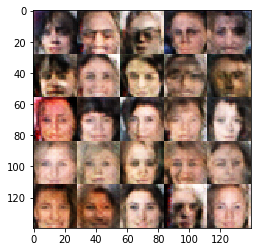

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7303


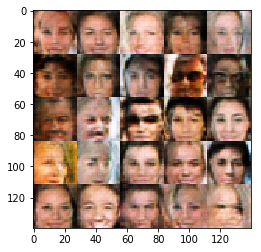

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6757


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.